In [23]:
import sys

sys.path.append('/Users/oscar/anaconda/envs/myenv/lib/python3.6/site-packages')

In [24]:
import cv2

In [40]:
from keras.applications import inception_v3
from keras import backend as K

# We will not be training our model,
# so we use this command to disable all training-specific operations
K.set_learning_phase(0)

# Build the InceptionV3 network.
# The model will be loaded with pre-trained ImageNet weights.
model = inception_v3.InceptionV3(weights='imagenet',
                                 include_top=False)

In [41]:
# Dict mapping layer names to a coefficient
# quantifying how much the layer's activation
# will contribute to the loss we will seek to maximize.
# Note that these are layer names as they appear
# in the built-in InceptionV3 application.
# You can list all layer names using `model.summary()`.
layer_contributions = {
    'mixed2': 0.2,
    'mixed3': 3.,
    'mixed4': 2.,
    'mixed5': 1.5,
}

In [42]:
# Get the symbolic outputs of each "key" layer (we gave them unique names).
layer_dict = dict([(layer.name, layer) for layer in model.layers])

# Define the loss.
loss = K.variable(0.)
for layer_name in layer_contributions:
    # Add the L2 norm of the features of a layer to the loss.
    coeff = layer_contributions[layer_name]
    activation = layer_dict[layer_name].output

    # We avoid border artifacts by only involving non-border pixels in the loss.
    scaling = K.prod(K.cast(K.shape(activation), 'float32'))
    loss += coeff * K.sum(K.square(activation[:, 2: -2, 2: -2, :])) / scaling

In [28]:
# This holds our generated image
dream = model.input

# Compute the gradients of the dream with regard to the loss.
grads = K.gradients(loss, dream)[0]

# Normalize gradients.
grads /= K.maximum(K.mean(K.abs(grads)), 1e-7)

# Set up function to retrieve the value
# of the loss and gradients given an input image.
outputs = [loss, grads]
fetch_loss_and_grads = K.function([dream], outputs)

def eval_loss_and_grads(x):
    outs = fetch_loss_and_grads([x])
    loss_value = outs[0]
    grad_values = outs[1]
    return loss_value, grad_values

def gradient_ascent(x, iterations, step, max_loss=None):
    for i in range(iterations):
        loss_value, grad_values = eval_loss_and_grads(x)
        if max_loss is not None and loss_value > max_loss:
            break
        print('...Loss value at', i, ':', loss_value)
        x += step * grad_values
    return x

In [163]:
import scipy
from keras.preprocessing import image
import cv2
import random

def resize_img(img, size):
    img = np.copy(img)
    factors = (1,
               float(size[0]) / img.shape[1],
               float(size[1]) / img.shape[2],
               1)
    return scipy.ndimage.zoom(img, factors, order=1)


# TODO: parameterize the amount of noise
def add_gaussian_noise(img, noise_sigma):
    noise_image = np.zeros(img.shape)
    noise_image = np.array([cv2.randn(noise_image[0],-0.1,0.1)])
    img = img + noise_image
    
    return img

# TODO: parameterize the amount of noise
def add_sp_noise(img):
    amount_of_noise = 0.002
    noise_percent = 100 * amount_of_noise
    num_p = np.ceil(amount_of_noise * img.shape[1] *img.shape[2] * 0.5)
    for mat in img:
        for i, row in enumerate(mat):
            for j, pixel in enumerate(row):
                r_int = random.randint(0, 10000)
                if r_int <= noise_percent * 100 * 0.5:
                    img[0][i][j][0] = 1
                    img[0][i][j][1] = 1
                    img[0][i][j][2] = 1
                r_int = random.randint(0, 10000)
                if r_int <= noise_percent * 100 * 0.5:
                    img[0][i][j][0] = -1
                    img[0][i][j][1] = -1
                    img[0][i][j][2] = -1

    return img


def save_img(img, fname):
    pil_img = deprocess_image(np.copy(img))
    scipy.misc.imsave(fname, pil_img)


def preprocess_image(image_path):
    # Util function to open, resize and format pictures
    # into appropriate tensors.
    img = image.load_img(image_path)
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = inception_v3.preprocess_input(img)
    return img


def deprocess_image(x):
    # Util function to convert a tensor into a valid image.
    if K.image_data_format() == 'channels_first':
        x = x.reshape((3, x.shape[2], x.shape[3]))
        x = x.transpose((1, 2, 0))
    else:
        x = x.reshape((x.shape[1], x.shape[2], 3))
    x /= 2.
    x += 0.5
    x *= 255.
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [164]:
import numpy as np

# Playing with these hyperparameters will also allow you to achieve new effects

step = 0.01  # Gradient ascent step size
num_octave = 3  # Number of scales at which to run gradient ascent
octave_scale = 1.4  # Size ratio between scales
iterations = 20  # Number of ascent steps per scale

noisy_sigma = 35

# If our loss gets larger than 10,
# we will interrupt the gradient ascent process, to avoid ugly artifacts
max_loss = 10.

# Fill this to the path to the image you want to use
base_image_path = '/Users/oscar/Documents/Development/Resources/images/ocean_sunset.jpg'

# Load the image into a Numpy array
img = preprocess_image(base_image_path)

# We prepare a list of shape tuples
# defining the different scales at which we will run gradient ascent
original_shape = img.shape[1:3]
successive_shapes = [original_shape]
for i in range(1, num_octave):
    shape = tuple([int(dim / (octave_scale ** i)) for dim in original_shape])
    successive_shapes.append(shape)

# Reverse list of shapes, so that they are in increasing order
successive_shapes = successive_shapes[::-1]

# Resize the Numpy array of the image to our smallest scale
original_img = np.copy(img)
shrunk_original_img = resize_img(img, successive_shapes[0])

for shape in successive_shapes:
    print('Processing image shape', shape)
    img = add_sp_noise(img)
    img = resize_img(img, shape)
    img = add_gaussian_noise(img, noisy_sigma)
    img = gradient_ascent(img,
                          iterations=iterations,
                          step=step,
                          max_loss=max_loss)
    upscaled_shrunk_original_img = resize_img(shrunk_original_img, shape)
    same_size_original = resize_img(original_img, shape)
    lost_detail = same_size_original - upscaled_shrunk_original_img

    img += lost_detail
    shrunk_original_img = resize_img(original_img, shape)
    save_img(img, fname='noisy_ocean_dream_at_scale_' + str(shape) + '.png')

save_img(img, fname='final_noisy_ocean_dream.png')

/Users/oscar/anaconda/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:600: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


Processing image shape (192, 280)
...Loss value at 0 : 0.950467
...Loss value at 1 : 1.44631
...Loss value at 2 : 2.06338
...Loss value at 3 : 2.78629
...Loss value at 4 : 3.56725
...Loss value at 5 : 4.20288
...Loss value at 6 : 4.83721
...Loss value at 7 : 5.4702
...Loss value at 8 : 6.00839
...Loss value at 9 : 6.60548
...Loss value at 10 : 7.20344
...Loss value at 11 : 7.65368
...Loss value at 12 : 8.17064
...Loss value at 13 : 8.65379
...Loss value at 14 : 9.15686
...Loss value at 15 : 9.65125
Processing image shape (270, 392)
...Loss value at 0 : 2.29709
...Loss value at 1 : 3.71956
...Loss value at 2 : 4.91092
...Loss value at 3 : 5.91723
...Loss value at 4 : 6.82036
...Loss value at 5 : 7.6316
...Loss value at 6 : 8.37173
...Loss value at 7 : 9.17975
...Loss value at 8 : 9.87561
Processing image shape (378, 550)
...Loss value at 0 : 2.62581
...Loss value at 1 : 4.11889
...Loss value at 2 : 5.50312
...Loss value at 3 : 6.90979
...Loss value at 4 : 8.43743


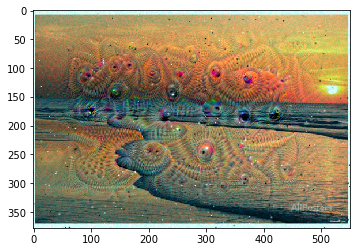

In [165]:
from matplotlib import pyplot as plt

plt.imshow(deprocess_image(np.copy(img)))
plt.show()